In [55]:
import sys

!{sys.executable} -m pip install ipywidgets
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pillow


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
import ipywidgets as widgets
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog
import os, io
from PIL import Image

In [57]:
# Fungsi augmentasi gambar
def augment_image(image):
    # Flip secara horizontal
    flipped_image = cv.flip(image, 1)
    
    # Rotasi kecil pada gambar
    rows, cols = image.shape[:2]
    M = cv.getRotationMatrix2D((cols / 2, rows / 2), 15, 1)
    rotated_image = cv.warpAffine(image, M, (cols, rows))
    
    return [image, flipped_image, rotated_image]

In [58]:
def preprocess_image(image):
    # Resize gambar ke ukuran yang seragam
    image = cv.resize(image, (128, 128))
    
    # Konversi gambar ke grayscale
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    # Normalisasi gambar
    gray_image = cv.normalize(gray_image, None, 0, 255, cv.NORM_MINMAX)
    
    # Penerapan Thresholding Otsu
    _, threshold_image = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    
    # Deteksi tepi menggunakan metode Canny
    edges = cv.Canny(threshold_image, 100, 200)
    
    # Ekstraksi fitur HOG dengan parameter yang lebih optimal
    features, _ = hog(edges, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    
    return features

In [59]:
# Fungsi untuk memuat dataset dari folder
def load_dataset_from_folders(dataset_path):
    features = []
    labels = []
    
    # Mendapatkan daftar label berdasarkan nama folder
    label_names = os.listdir(dataset_path)
    
    for label in label_names:
        label_folder = os.path.join(dataset_path, label)
        
        # Pastikan hanya membaca folder (bukan file lain)
        if os.path.isdir(label_folder):
            for img_name in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_name)
                
                # Baca gambar
                img = cv.imread(img_path)
                
                # Pastikan gambar terbaca dengan benar
                if img is not None:
                    # Lakukan augmentasi gambar
                    augmented_images = augment_image(img)
                    
                    # Preprocessing dan ekstraksi fitur pada setiap augmented image
                    for aug_img in augmented_images:
                        img_features = preprocess_image(aug_img)
                        features.append(img_features)
                        labels.append(label)
                else:
                    print(f"Warning: Gambar {img_path} tidak dapat dibaca.")
    
    return np.array(features), np.array(labels)

In [60]:
# Path ke folder dataset
dataset_path = 'train/'  # Ganti dengan path sebenarnya

# Memuat fitur dan label
X, y = load_dataset_from_folders(dataset_path)

In [61]:
# Konversi label ke bentuk numerik menggunakan LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [62]:
# Bagi dataset menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Menggunakan PCA untuk reduksi dimensi
pca = PCA(n_components=50)  # Jumlah komponen bisa disesuaikan
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [63]:
# Parameter yang ingin diuji dalam GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

In [64]:
# Grid search dengan cross-validation
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_pca, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=0.1, 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [65]:
# Model terbaik setelah tuning parameter
best_model = grid.best_estimator_

In [66]:
# Prediksi pada testing set
y_pred = best_model.predict(X_test_pca)

In [67]:
# Evaluasi akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Best model accuracy: {accuracy * 100:.2f}%")

Best model accuracy: 59.77%


In [68]:
# Fungsi untuk memprediksi nilai uang dari gambar baru
def predict_currency(image_path, model, label_encoder, pca_model):
    img = cv.imread(image_path)
    
    if img is None:
        print(f"Error: Gambar {image_path} tidak dapat dibaca.")
        return None
    
    # Preprocessing dan ekstraksi fitur
    features = preprocess_image(img)
    
    # Transformasi fitur menggunakan PCA
    features_pca = pca_model.transform([features])
    
    # Prediksi dengan model terbaik
    prediction = model.predict(features_pca)
    
    # Konversi prediksi menjadi label asli
    predicted_label = label_encoder.inverse_transform(prediction)

    return predicted_label[0]

In [69]:
# Fungsi untuk memproses gambar OpenCV yang diberikan dari file yang diunggah
def predict_currency_from_cv_image(img, model, label_encoder, pca_model):
    # Preprocessing dan ekstraksi fitur
    features = preprocess_image(img)
    
    # Transformasi fitur menggunakan PCA
    features_pca = pca_model.transform([features])
    
    # Prediksi dengan model terbaik
    prediction = model.predict(features_pca)
    
    # Konversi prediksi menjadi label asli
    predicted_label = label_encoder.inverse_transform(prediction)

    return predicted_label[0]

In [70]:
# Fungsi untuk membaca file yang diunggah dari widget
def on_upload_change(change):
    # Ambil konten file yang diunggah
    uploaded_file = change['new']
    
    if uploaded_file:
        # Mengakses file yang diunggah (bisa berbentuk list/tuple)
        for file_name in uploaded_file:
            print(f"File uploaded: {file_name.name}")
            
            # Baca file menggunakan PIL
            img = Image.open(io.BytesIO(file_name['content']))
            
            # Konversi PIL image ke format OpenCV
            img_cv = cv.cvtColor(np.array(img), cv.COLOR_RGB2BGR)
            
            # Lakukan prediksi
            predicted_value = predict_currency_from_cv_image(img_cv, best_model, le, pca)
            print(f"Predicted Currency Value: Rp{predicted_value}")
            
            # Tampilkan gambar menggunakan matplotlib
            plt.imshow(img)
            plt.title(f"Predicted Currency Value: Rp{predicted_value}")
            plt.axis('off')  # Hilangkan sumbu
            plt.show()

FileUpload(value=(), accept='image/*', description='Upload')

File uploaded: 1k.jpeg
Predicted Currency Value: Rp1000


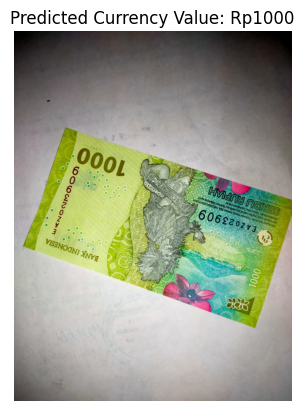

File uploaded: 50k.jpg
Predicted Currency Value: Rp50000


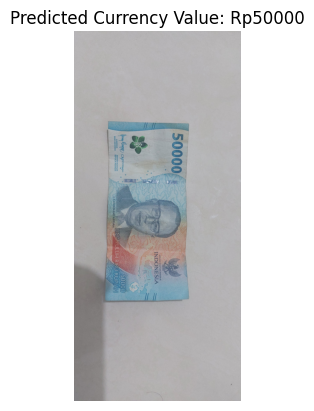

File uploaded: 10k-2.jpeg
Predicted Currency Value: Rp5000


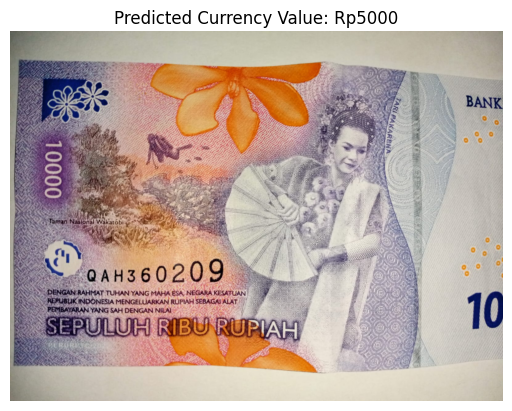

In [74]:
# Buat widget untuk mengunggah gambar
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

# Tampilkan widget
display(upload_widget)

# Daftarkan fungsi untuk menangani event saat file diunggah
upload_widget.observe(on_upload_change, names='value')